## GPcounts with zero-inflated negative binomial likelihood

Nuha BinTayyash, 2020

This notebook comapre GPcount fit with zero-inflated negative binomial, negative binomial and Gaussian likelihoods on ScRNA-seq gene expression data for highly expressed genes in Islet $\alpha$ cell from [GSE8737 single cell RNA-seq ](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE87375) dataset.

In [1]:
import pandas as pd
import numpy as np
import gpflow 

Load $\alpha$ dataset and pseudotime information

In [2]:
Y = pd.read_csv('alpha_counts.csv',index_col=[0])
X = pd.read_csv('alpha_time_points.csv',index_col=[0])

#### Fit GPcount with zero inflated negative binomial likelihood

In [3]:
from GPcounts.GPcounts_Module import Fit_GPcounts

In [4]:
gene_name = ['Fam184b','Pde1a']
gp_counts = Fit_GPcounts(X,Y.loc[gene_name]) 

Probabilty of zeros in Fam184b and Pde1a genes

In [5]:
Y.loc[gene_name][Y.loc[gene_name] == 0].count(axis=1)/len(Y.columns)

Symbol
Fam184b    0.862805
Pde1a      0.689024
dtype: float64

In [6]:
from matplotlib import pyplot as plt
import statsmodels.api as sm

def plot():
    plt.tick_params(labelsize='large', width=2)     
    #plt.ylabel('Gene Expression', fontsize=16)
    #plt.xlabel('Times', fontsize=16)
    
    if model_index == 1 or model_index == 2:
        c = 'blue'
        m = 'o'

    else:
        c = 'salmon'
        m = '^'
    
    if likelihood == 'Gaussian':
        plt.fill_between(xtest[:,0],
                            mean[:,0] - 1*np.sqrt(var[:,0]),
                            mean[:,0] + 1*np.sqrt(var[:,0]),alpha=0.2) # one standard deviation
        plt.fill_between(xtest[:,0],
                            mean[:,0] - 2*np.sqrt(var[:,0]),
                            mean[:,0] + 2*np.sqrt(var[:,0]),color='light'+c, alpha=0.2)# two standard deviation
    else:
       
        lowess = sm.nonparametric.lowess    
        # one standard deviation 68%
        percentile_16 = lowess(np.percentile(var, 16, axis=0),xtest[:,0],frac=1./5, return_sorted=False)
        percentile_16 = [(i > 0) * i for i in percentile_16]
        percentile_84 = lowess(np.percentile(var, 84, axis=0),xtest[:,0],frac=1./5, return_sorted=False)
        percentile_84 = [(i > 0) * i for i in percentile_84]
        plt.fill_between(xtest[:,0],percentile_16,percentile_84,alpha = 0.2)
        
        # two standard deviation 95%
        percentile_5 = lowess(np.percentile(var, 5, axis=0),xtest[:,0],frac=1./5, return_sorted=False)
        percentile_5 = [(i > 0) * i for i in percentile_5]
        percentile_95 = lowess(np.percentile(var,95, axis=0),xtest[:,0],frac=1./5, return_sorted=False)
        percentile_95 = [(i > 0) * i for i in percentile_95]
        plt.fill_between(xtest[:,0],percentile_5,percentile_95,color='light'+c,alpha = 0.2)
        
    plt.plot(xtest, mean,color= c, lw=2, alpha=0.7) 
    
    if test == 'Two_samples_test':
        if model_index == 1:
            plt.scatter(model.data[0][0:int(model.data[0].shape[0]/2)],model.data[1][0:int(model.data[0].shape[0]/2)], s=30, marker='o', color= 'blue', alpha=0.7) #data    
            plt.scatter(model.data[0][int(model.data[0].shape[0]/2)::],model.data[1][int(model.data[0].shape[0]/2)::], s=30, marker='^', color= 'salmon', alpha=0.7) #data
            
            plt.show()
        else: 
            plt.scatter(model.data[0],model.data[1],s=30,marker = m, color=c, alpha=0.7)
            
            if model_index == 3:
                plt.show()
    
    else:
        plt.scatter(model.data[0],model.data[1], s=30, color= c, alpha=0.7) #data
        plt.show()

In [7]:
likelihood = 'Zero_inflated_negative_binomial' 
log_likelihood_zinb = gp_counts.Infer_trajectory(likelihood)
log_likelihood_zinb

100%|██████████| 2/2 [00:41<00:00, 20.51s/it]


,Dynamic_model_log_likelihood
Fam184b,-295.271165
Pde1a,-598.080047


100%|██████████| 2/2 [00:01<00:00,  1.40it/s]


Fam184b


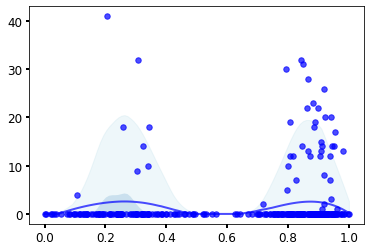

Pde1a


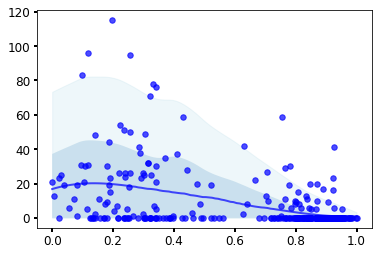

In [8]:
likelihood = 'Zero_inflated_negative_binomial' 
indexes = log_likelihood_zinb.index.values.tolist() # list of genes to be plotted 
test = 'Infer_trajectory' # name of the test
xtest = np.linspace(np.min(X.values),np.max(X.values),100)[:,None]

params = gp_counts.load_models(indexes,test,xtest,likelihood)

for i in range(len(indexes)):
    fig = plt.figure()
    print(indexes[i])
    model_index = 1
    for model,mean,var in zip(params['models'][i],params['means'][i],params['vars'][i]):
        plot()
        model_index = model_index + 1

#### Fit GPcount with negative binomial likelihood

In [9]:
likelihood = 'Negative_binomial' 
log_likelihood_nb = gp_counts.Infer_trajectory(likelihood)
log_likelihood_nb

100%|██████████| 2/2 [00:14<00:00,  7.24s/it]


,Dynamic_model_log_likelihood
Fam184b,-316.895256
Pde1a,-642.953417


100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


Fam184b


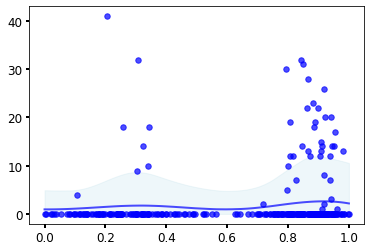

Pde1a


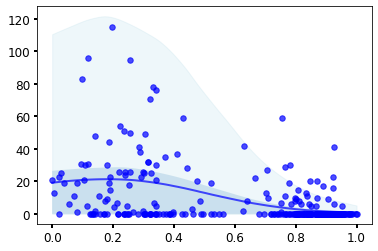

In [10]:
likelihood = 'Negative_binomial'
params = gp_counts.load_models(indexes,test,xtest,likelihood)
for i in range(len(indexes)):
    fig = plt.figure()
    print(indexes[i])
    model_index = 1
    for model,mean,var in zip(params['models'][i],params['means'][i],params['vars'][i]):
        plot()
        model_index = model_index + 1

#### Fit GPcount with Gaussian likelihood

In [11]:
likelihood = 'Gaussian'
log_likelihood = gp_counts.Infer_trajectory(likelihood)
log_likelihood

100%|██████████| 2/2 [00:01<00:00,  1.31it/s]


,Dynamic_model_log_likelihood
Fam184b,-442.142330
Pde1a,-537.039584


100%|██████████| 2/2 [00:00<00:00, 26.62it/s]


Fam184b


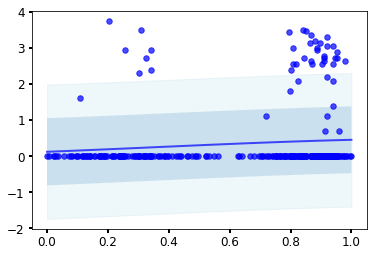

Pde1a


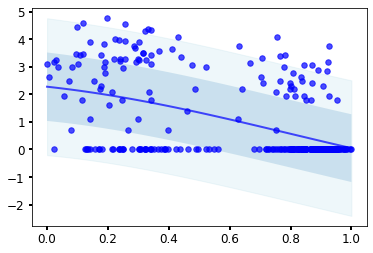

In [12]:
params = gp_counts.load_models(indexes,test,xtest,likelihood)

for i in range(len(indexes)):
    fig = plt.figure()
    print(indexes[i])
    model_index = 1
    for model,mean,var in zip(params['models'][i],params['means'][i],params['vars'][i]):
        plot()
        model_index = model_index + 1